In [1]:
import numpy as np
from scipy import interpolate
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import Point
import matplotlib.pyplot as plt
from GISio import shp2df

%matplotlib inline

## Zonal statistics with `rasterstats`
* the `zonal_stats` function samples raster values within a specified list of polygons
* more info: https://github.com/perrygeo/python-rasterstats

#### make some circles using `shapely Point` features


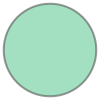

In [2]:
p1 = Point(-91.19, 43.82)
p2 = Point(-91.27, 43.86)
c1 = p1.buffer(.02)
c2 = p2.buffer(.02)
c1

In [3]:
list(c2.exterior.coords)[0:5]

[(-91.25, 43.86),
 (-91.25009630546656, 43.85803965719341),
 (-91.25038429439194, 43.856098193559674),
 (-91.25086119328535, 43.85419430645491),
 (-91.25152240934977, 43.8523463313527)]

In [4]:
counties = shp2df('data/counties.shp')
counties


reading data/counties.shp...
--> building dataframe... (may take a while for large shapefiles)


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,55,063,01581091,55063,La Crosse,La Crosse County,06,H1,G4020,None,29100,None,A,1170030643,73154545,+43.9082222,-091.1117584,"POLYGON ((-91.347741 43.911964, -91.348743 43...."
1,55,123,01581121,55123,Vernon,Vernon County,06,H1,G4020,None,None,None,A,2050129169,64295772,+43.5993661,-090.8219835,"POLYGON ((-91.150639 43.725537, -91.150015 43...."
2,27,169,00659529,27169,Winona,Winona County,06,H1,G4020,None,49100,None,A,1621568469,40121648,+43.9822682,-091.7767076,"POLYGON ((-92.07949099999999 44.106988, -92.07..."
3,27,055,00659473,27055,Houston,Houston County,06,H1,G4020,None,29100,None,A,1429784548,43496132,+43.6669899,-091.5015556,"POLYGON ((-91.31496799999999 43.847065, -91.31..."


### Plot the DEM in real-world coordinates (with the polygons to be sampled)
* note: it looks like the latest version of `rasterio` [has this built in]( https://github.com/mapbox/rasterio/blob/master/examples/Data%20visualization.ipynb)  
(I couldn't get the real world coordinates to show up when I tried though)  
* [CartoPy](http://scitools.org.uk/cartopy/) is a mapping package that seems to be gaining traction. It can also plot images in real world coordinates
* this method is slow for large rasters because `matplotlib` is drawing a patch object for each pixel

In [5]:
# open the file
with rasterio.open('data/lc.tif') as src:
    
    # read the data into a numpy array
    img = src.read(1)
    
    # make a mesh grid of pixel locations
    x1, y1, x2, y2 = src.bounds
    x = np.add.accumulate(np.ones(src.width) * src.res[0]) + x1
    y= np.add.accumulate(np.ones(src.height) * src.res[1]) + y1
    X, Y = np.meshgrid(x, y)

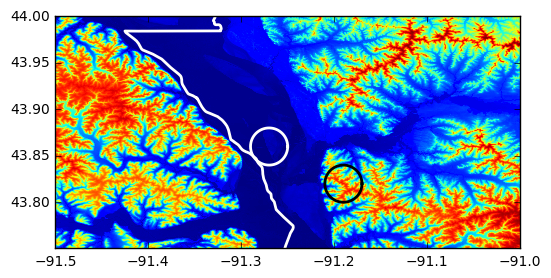

In [6]:
fig, ax = plt.subplots()
ax.pcolormesh(X, Y, np.flipud(img))

# drop the circles and LaCrosse County on top
plt.plot(*zip(*c1.exterior.coords), color='k', linewidth=2)
plt.plot(*zip(*c2.exterior.coords), c='w', linewidth=2)
plt.plot(*zip(*counties.loc[counties.NAME == 'La Crosse', 'geometry'][0].exterior.coords), c='w', linewidth=2)

ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)
ax.set_aspect(1)

### Run `zonal_stats` on the circles, and La Crosse County
* we can call the raster file directly, so we don't have to deal with it in memory (much faster)
* by default, count, max, mean, and min are returned
* other stats can be specified with the `stats` argument
* the DEM elevations are in m

In [7]:
from rasterstats.utils import VALID_STATS
VALID_STATS

['count',
 'min',
 'max',
 'mean',
 'sum',
 'std',
 'median',
 'majority',
 'minority',
 'unique',
 'range',
 'nodata']

In [8]:
stats = zonal_stats([c1, c2, counties.geometry[3]], 'data/lc.tif', 
                    stats=['count', 'min', 'max', 'mean', 'median', 'std'])

In [9]:
stats

[{'count': 146348,
  'max': 391.2250671386719,
  'mean': 322.56703200590374,
  'median': 331.5994873046875,
  'min': 211.53988647460938,
  'std': 44.97366752325466},
 {'count': 146348,
  'max': 208.11529541015625,
  'mean': 196.09254653292152,
  'median': 194.03958129882812,
  'min': 191.46209716796875,
  'std': 3.785983867622992},
 {'count': 2671327,
  'max': 396.7962341308594,
  'mean': 260.54557603767717,
  'median': 242.3273162841797,
  'min': 191.69000244140625,
  'std': 60.42268509723354}]

#### Note that the second circle has a much lower standard deviation because it is out on the flood plain

## Focal statistics using `zonal_stats`
* similar to the [ArcMap tool](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/focal-statistics.htm)
* iterate over the raster pixels, using a shapely feature to define the area to aggregate  
(can use any arbitrary shape to define neighborhood)
* note: this approach becomes prohibitively slow with large rasters

#### make a list of the pixel locations using the mesh grid from above
first cut it down to a smaller size (the full raster has 14.6M pixels)

In [10]:
points = list(zip(X[:100, :100].ravel(), np.flipud(Y)[:100, :100].ravel()))

In [11]:
rad = 0.001 # radius of area to aggregate around each pixel, degrees
buffers = [Point(x, y).buffer(rad) for x, y in points]

In [12]:
buffers = []
for x, y in points:
    buffers.append(Point(x, y).buffer(rad))

In [13]:
zstats = zonal_stats(buffers, 'data/lc.tif', stats='std')

# convert the results from a list of dictionaries to 2D array
# (of same shape as original raster)
zstats_array = np.reshape([d['std'] for d in zstats], (100, 100))

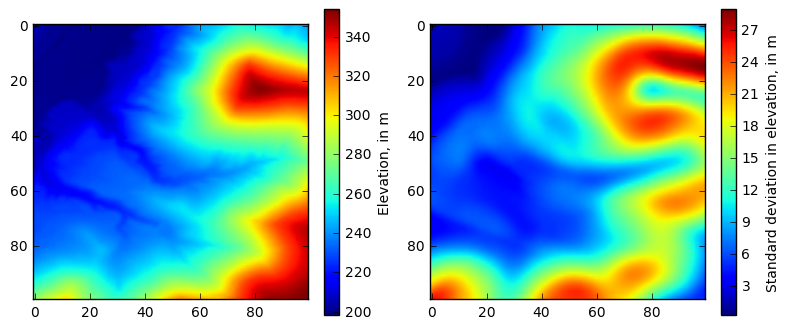

In [14]:
with rasterio.open('data/lc.tif') as src:
    img = src.read(1, window=((0, 100), (0, 100)))

fig, axes = plt.subplots(1, 2, figsize=(8, 6))
z = axes[0].imshow(img)
fig.colorbar(z, ax=axes[0], fraction=0.05, label='Elevation, in m')
std = axes[1].imshow(zstats_array)
fig.colorbar(std, ax=axes[1], fraction=0.05, label='Standard deviation in elevation, in m')
plt.tight_layout()

## Focal statistics by deferencing

#### start by padding the array
* we want to have a single function to return neighborhood values for anywhere on the array, including the edges
* pad the edges with nodata values so that the pixel neighborhood doesn't extent past the edges
* many rasters will have areas of no data values around the edges anyways, especially if they've been reprojected

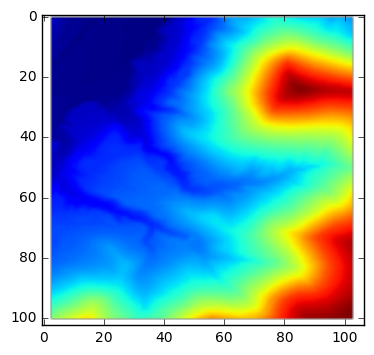

In [15]:
neighborhood = ((1, 2), (3, 4)) # ((rows before, rows after), (columns before, columns after))
padded = np.pad(img, neighborhood, 'constant', constant_values=np.nan)
plt.imshow(padded)

### Slice away the padding, using the indices supplied for the neighborhood above
this is the area of the padded array that we will iterate over

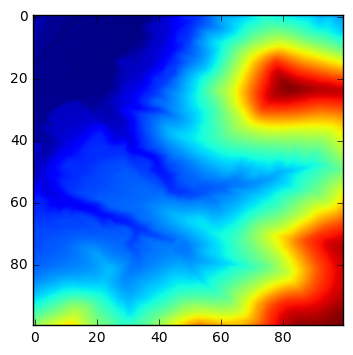

In [16]:
n = neighborhood
plt.imshow(padded[n[0][0]:-n[0][1], n[1][0]:-n[1][1]])

### Make a function to get the neighboring pixels

In [17]:
def get_neighbors(a, r, c, neighborhood=((1, 1), (1, 1))):
    rb, ra = neighborhood[0]
    cb, ca = neighborhood[1]
    return a[r-rb:r+ra, c-cb:c+ca]

#### Neighborhood of the first pixel in the original array

In [18]:
nb = get_neighbors(padded, 1, 3, neighborhood=neighborhood)
nb

array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan],
       [          nan,           nan,           nan,  206.26487732,
         205.56434631,  204.50158691,  203.73838806],
       [          nan,           nan,           nan,  206.51202393,
         205.94847107,  205.09562683,  203.88800049]], dtype=float32)

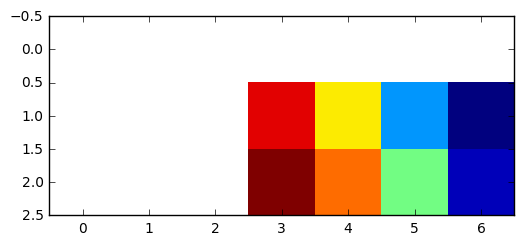

In [19]:
plt.imshow(get_neighbors(padded, 1, 3, neighborhood=neighborhood), interpolation='none')

#### drop the nans

In [20]:
nb[~np.isnan(nb)]

array([ 206.26487732,  205.56434631,  204.50158691,  203.73838806,
        206.51202393,  205.94847107,  205.09562683,  203.88800049], dtype=float32)

### Compute standard deviation for padded array  
* use the neighborhood indices to define the row/column ranges to iterate over  
* use `get_neighbors()` to return the neighboring pixes

In [21]:
# first set up an empty array to house the computed values
stats = np.empty_like(img) # make the output array have same dimmensions as original (non-padded) array

r0, c0 = neighborhood[0][0], neighborhood[1][0]
n = neighborhood
for r in range(r0, img.shape[0] + r0):
    for c in range(c0, img.shape[1] + c0):
        nb = get_neighbors(padded, r, c, neighborhood=neighborhood)
        nb = nb[~np.isnan(nb)] # drop the nans
        stats[r-r0, c-c0] = np.std(nb)

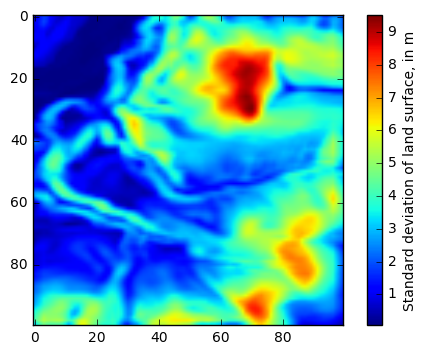

In [22]:
plt.imshow(stats)
plt.colorbar(label='Standard deviation of land surface, in m')

## Wrap above code into single function to compute focal statistics on any raster

In [23]:
def focal_stats(a, neighborhood=((1, 1), (1, 1)), 
                step=1,
                stat_function=np.std,
                nan_values=np.nan):
    
    # set no-data values to np.nan if they aren't already
    if not np.isnan(nan_values):
        a[a == nan_values] = np.nan
        
    # pad the array based on the neighborhood rectangle
    padded = np.pad(a, neighborhood, 'constant', constant_values=np.nan)
    
    # function to get the neighbors
    def get_neighbors(a, r, c, neighborhood=((1, 1), (1, 1))):
        rb, ra = neighborhood[0]
        cb, ca = neighborhood[1]
        return a[r-rb:r+ra, c-cb:c+ca]
    
    # empty array to house the computed values
    stats = np.zeros_like(a) # same dimmensions as a
    
    
    # first row and column with valid values
    nrow, ncol = a.shape
    r0, c0 = neighborhood[0][0], neighborhood[1][0]
    for r in range(r0, nrow + r0, step):
        for c in range(c0, ncol + c0, step):
            nb = get_neighbors(padded, r, c, neighborhood=neighborhood)
            nb = nb[~np.isnan(nb)] # drop the nans
            stats[r-r0, c-c0] = stat_function(nb)
    
    # if statistics were only calculated for every step pixels,
    # interpolate to fill values in between
    if step > 1:
        z = stats[::step, ::step]
        f = interpolate.interp2d(np.arange(ncol)[::step], 
                                 np.arange(nrow)[::step],
                                 z, kind='linear')
        xx, yy = np.arange(ncol), np.arange(nrow)
        statsint = f(xx, yy)
        return statsint
    return stats

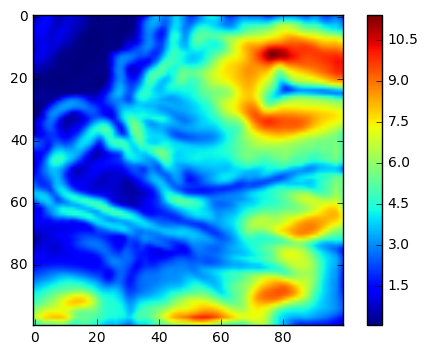

In [24]:
plt.imshow(focal_stats(img, step=1, stat_function=np.std, neighborhood=((3, 3), (3, 3))))
plt.colorbar()

### Compute standard deviation for the whole DEM  
* use a step size > 1 to save time
* `focal_stats` will fill the gaps in between using bilinear interpolation

In [25]:
with rasterio.open('data/lc.tif') as src:
    img = src.read(1)
    stats = focal_stats(img, step=8, stat_function=np.std, neighborhood=((3, 3), (3, 3)))

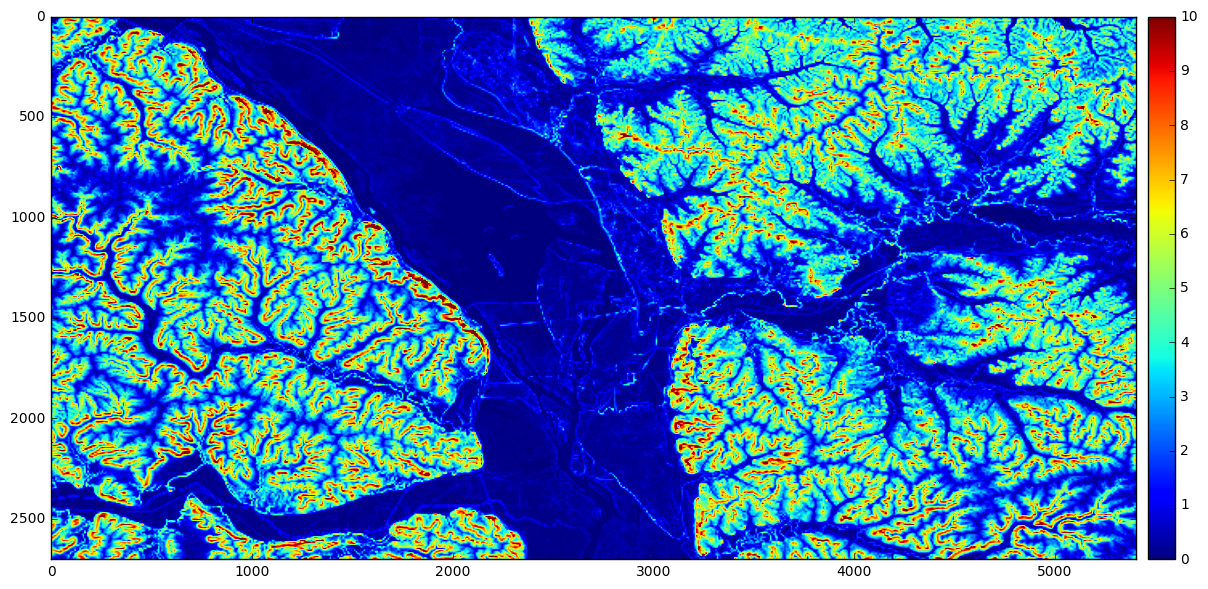

In [26]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.imshow(stats, vmax=10, interpolation='none')
plt.colorbar(fraction=0.03, pad=0.01)

### Write the standard deviaton raster out to a GeoTiff file
check it out in a GIS!

In [27]:
with rasterio.open('data/lc.tif') as src:
    
    # copy the properties/metadata from the original raster
    kwargs = src.meta.copy()
    kwargs['dtype'] = 'float64' # update the dtype
    # delete the old-style transform 
    # (may not need to do this in later versions of rasterio)
    del kwargs['transform']
    
    with rasterio.open('data/lc_std.tif', 'w', **kwargs) as dest:
        dest.write(stats, 1) # write the data to band 1

In [28]:
kwargs

{'affine': Affine(9.2592592593e-05, 0.0, -91.50000000000225,
       0.0, -9.2592592593e-05, 44.000555555555515),
 'count': 1,
 'crs': CRS({'init': 'epsg:4269'}),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 2703,
 'nodata': -3.4028234663852886e+38,
 'width': 5406}